#Building Pipeline for engine rating prediction assignment using Kedro

##Installing kedro

In [ ]:
!pip install kedro

In [2]:
!kedro info

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa

 _            _
| | _____  __| |_ __ ___
| |/ / _ \/ _` | '__/ _ \
|   <  __/ (_| | | | (_) |
|_|\_\___|\__,_|_|  \___/
v0.17.5

kedro allows teams to create analytics
projects. It is developed as part of
the Kedro initiative at QuantumBlack.

No plugins installed


##Creating a new project on kedro

In [3]:
!kedro new

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa

Project Name:
Please enter a human readable name for your new project.
Spaces and punctuation are allowed.
 [New Kedro Project]: Engine Rating

Repository Name:
Please enter a directory name for your new project repository.
Alphanumeric characters, hyphens and underscores are allowed.
Lowercase is recommended.
 [engine-rating]: 

Python Package Name:
Please enter a valid Python package name for your project package.
Alphanumeric characters and underscores are allowed.
Lowercase is recommended. Package name must start with a letter
or underscore.
 [engine_rating]: 

Change directory to the project generated in /content/engine-rating

A best-practice setup includes initialising git and creating a virtual e

This will create a directory as shown below:

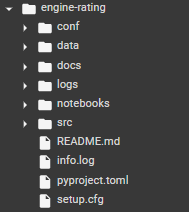

In [ ]:
import os
os.chdir('/content/engine-rating') #changing the directory
!kedro install #installing dependencies

##Creating a new pipelines : This will create a pipeline with default kedro templates

Pipeline 1 - data cleaning<br>
Pipeline 2 - data eda<br>
Pipeline 3 - feature engineering<br>
Pipeline 4 - model training<br>

In [ ]:
!kedro pipeline create data_cleaning
!kedro pipeline create data_eda
!kedro pipeline create feature_engineering
!kedro pipeline create model_training

This will create 4 pipelines in the folder src as shown below:

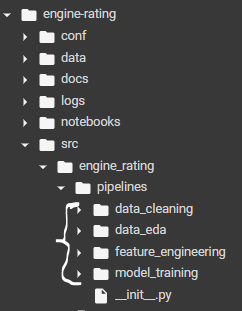

Each of these pipelines will have node.py and pipeline.py files with default templates. We will update these files for all the 4 pipelines according to our requirements. 

###Pipeline 1 : data_cleaning

In [ ]:
#defining the functions for data cleaning
#write this code in the nodes.py file
import pandas as pd
def cleaning(df):
    print("\nThe dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))
    print("\nThe class label distribution is as shown below\n")
    print(df['rating_engineTransmission'].value_counts())
    print("\nDropping feature appointment_id as it is just an index")
    df = df.drop('appointmentId',axis=1)
    col1 = df.columns

    print("\nRemoving duplicates ")
    df = df.drop_duplicates(keep='first')
    df = df.T.drop_duplicates().T
    col2 = df.columns

    print("{} is a duplicate column and is removed".format(set(col1) ^ set(col2)))
    print("Shape of the dataset after data cleaning :", df.shape)
    return df

In [ ]:
#defining the pipeline using above functions
#write this code in pipeline.py file
from kedro.pipeline import Pipeline, node
from .nodes import cleaning

def create_pipeline(**kwargs):
    return Pipeline(
            [
                node(func=cleaning,inputs='raw_data',outputs='clean_data',name='data_cleaning'),
            ])


###Pipeline 2 : data_eda

In [ ]:
#defining the functions for data cleaning
#write this code in the nodes.py file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
def missing_column_count(df):
    missing_feature_count = dict(df.drop('rating_engineTransmission',axis=1).isnull().sum())
    missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda x:x[1],reverse=True))
    print("Printing few missing value features")
    c=0
    for k,v in missing_feature_count.items():
        if v/len(df) > .99:
            print('column: {} , missing_count: {}'.format(k, v))
            c=c+1
    print("="*100)
    print("The number of features with 99% of its values missing are : ", c)
    return missing_feature_count

def drop_empty_features(df):
    df = df.drop('engineTransmission_engineOil_cc_value_9',axis=1)
    print("Shape of dataframe after droping features with all values missing :",df.shape)
    return df

def barplot(df): 
    fig, ax = plt.subplots()
    sns.barplot(x=df['rating_engineTransmission'].value_counts().index, y=df['rating_engineTransmission'].value_counts().values,ax=ax)
    plt.title('Frequency Distribution of Target Variable')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Engine Rating', fontsize=12)
    print(df['rating_engineTransmission'].value_counts())
    return fig

def remove_rating_1(df):
    df.drop(16022,inplace=True)
    df = df.reset_index(drop=True)
    print("Removed the datapoint with engine rating 1.0, since only one datapoint had rating 1.0")
    return df

def univariate_barplots(df,col1,col2):
    print("Univariate analysis on feature :",col1)
    df=df.fillna('Entry Missing')
    temp = df.groupby(col1)[col2]
    l = len(temp)
    fig,axes = plt.subplots(1,l,figsize=(40,10))
    c=0
    for i,j in temp:
        sns.barplot(x=j.value_counts(dropna=False).keys(),y=j.value_counts(dropna=False),ax=axes[c])
        axes[c].set_title(i)
        axes[c].set_ylabel('Number of Occurrences', fontsize=12)
        axes[c].set_xlabel('Engine Rating', fontsize=12)
        c+=1
    return fig

def univariate_analysis(df):
    print("Univariate analysis on some features with missing values greater than 90%")
    fig1=univariate_barplots(df,col1 = 'engineTransmission_clutch_cc_value_6',col2 = 'rating_engineTransmission')
    fig2=univariate_barplots(df,col1 = 'engineTransmission_engineOil_cc_value_8',col2 = 'rating_engineTransmission')
    fig3=univariate_barplots(df,col1 = 'engineTransmission_coolant_cc_value_1',col2 = 'rating_engineTransmission')

    print("Univariate analysis on some features with missing values less than 50%")
    fig4=univariate_barplots(df,col1 = 'engineTransmission_engineSound_cc_value_1',col2 = 'rating_engineTransmission')
    fig5=univariate_barplots(df,col1 = 'engineTransmission_engineSound_cc_value_0',col2 = 'rating_engineTransmission')
    fig6=univariate_barplots(df,col1 = 'engineTransmission_engineOil_cc_value_0',col2 = 'rating_engineTransmission')

    print("Univariate Analysis on some categorical features with category as [Yes or No].")
    fig7=univariate_barplots(df,col1 = 'engineTransmission_battery_value',col2 = 'rating_engineTransmission')
    fig8=univariate_barplots(df,col1 = 'engineTransmission_engineoilLevelDipstick_value',col2 = 'rating_engineTransmission')
    fig9=univariate_barplots(df,col1 = 'engineTransmission_engineOil',col2 = 'rating_engineTransmission')
    return fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8,fig9

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def numerical_feature_processing(df):
    insp_dates = pd.DatetimeIndex(df['inspectionStartTime'])
    man_year = df['year']
    man_month = df['month']
    age = []
    for i in range(len(df)):
        age.append(diff_month(insp_dates[i],datetime(man_year[i],man_month[i],1)))
    df['Age'] = age
    df = df.drop(['inspectionStartTime','year','month'],axis=1)
    fig1 = numerical_feature_analysis(df,col1='odometer_reading',col2='rating_engineTransmission')
    fig2 = numerical_feature_analysis(df,col1='Age',col2='rating_engineTransmission')
    return df,fig1,fig2

def numerical_feature_analysis(df,col1,col2):
    fig, ax = plt.subplots()
    sns.kdeplot(x=col1, data=df, hue=col2, cumulative=False, common_norm=False)
    return fig


In [ ]:
#defining the pipeline using above functions
#write this code in pipeline.py file
from kedro.pipeline import Pipeline, node
from .nodes import missing_column_count,drop_empty_features,barplot,remove_rating_1,\
univariate_analysis,numerical_feature_analysis,univariate_barplots,diff_month,numerical_feature_processing

def create_pipeline(**kwargs):
    return Pipeline(
            [node(func=missing_column_count, inputs="clean_data",outputs="missing_count",name="missing_feature_count"),
             node(func=drop_empty_features, inputs="clean_data",outputs="clean_data_2", name="drop_empty_features"),
             node(func=barplot, inputs="clean_data_2",outputs="target_plot",name="barplot"),
	     node(func=remove_rating_1, inputs="clean_data_2",outputs="clean_data_3",name="remove_rating_1"),
             node(func=univariate_analysis, inputs="clean_data_3",outputs=["fig1","fig2","fig3","fig4","fig5","fig6","fig7","fig8","fig9"],name="univariate_analysis"),
             node(func=numerical_feature_processing,inputs="clean_data_3",outputs=["data_after_eda","fig10","fig11"],name="numerical_feature_processing"),
            ])



###Pipeline 3 : feature_engineering

In [ ]:
#defining the functions for data cleaning
#write this code in the nodes.py file
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
def missing_feature_cols(df):
    missing_feature_count = dict(df.drop('rating_engineTransmission',axis=1).isnull().sum())
    missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda x:x[1],reverse=True))
    missing_feature_cols = []
    for k,v in missing_feature_count.items():
        if v/len(df) != 0.0:
            missing_feature_cols.append(k)
    print("="*100)
    print("The number of features that has missing values  : ", len(missing_feature_cols))
    fe_cols=[]
    for col in missing_feature_cols:
        df[col+'_fe']= df[col].isnull().astype(int)
        fe_cols.append(col+'_fe')
    feature_cols = list(df.columns)
    feature_cols = set(feature_cols) ^ set(fe_cols)
    feature_cols.remove('rating_engineTransmission')
    df = df.fillna('Null')
    return df,feature_cols,fe_cols

def train_cv_test_split(df):
    y = df['rating_engineTransmission']
    X = df.drop('rating_engineTransmission',axis=1)
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
    
    y_train = y_train*10
    y_train = y_train.astype(int)
    y_cv = y_cv*10
    y_cv = y_cv.astype(int)
    y_test = y_test*10
    y_test = y_test.astype(int)

    print(X_train.shape, y_train.shape)
    print(X_cv.shape, y_cv.shape)
    print(X_test.shape, y_test.shape)

    return X_train,y_train,X_cv,y_cv,X_test,y_test

def fit_response_encoding(X_train_feature,y_train):
  classes = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
  unique = np.unique(X_train_feature)
  l = np.array([X_train_feature,y_train])
  df = pd.DataFrame(l.T)
  d={}
  count = df.pivot_table(index =[0,1],aggfunc='size') 
  #print(count)
  for i in unique:
    res_enc=[]
    denom = np.count_nonzero(X_train_feature==i)
    #print("denom :",denom)
    for target in classes:
      if target in count[i].keys():
        res_enc.append((count[i][target])/denom)
      else:
        res_enc.append(0)    
    d[i] = res_enc
  return d

def transfrom_response_encoding(X_transform,d):
  encode=[]
  for i in X_transform:
    if i in d:
      encode.append(d[i])
    else:
      encode.append([0.5]*9)
  return np.array(encode)

def response_encoding(feature_cols,X_train,X_cv,X_test,y_train,y_cv,y_test):
    feature_cols.remove('Age')
    feature_cols.remove('odometer_reading')
    encoded_features=[]
    for feature in feature_cols:
        d = fit_response_encoding(X_train[feature],y_train)
        X_train_feature = transfrom_response_encoding(X_train[feature],d)
        X_cv_feature = transfrom_response_encoding(X_cv[feature],d)
        X_test_feature = transfrom_response_encoding(X_test[feature],d)
        encoded_features.append((X_train_feature,X_cv_feature,X_test_feature))

        print("After Vectorization, {} dimension changed to :".format(feature))
        print("="*50)
        print(X_train_feature.shape)
        print(X_cv_feature.shape)
        print(X_test_feature.shape)
        print("="*50)
    return encoded_features

def encoding_numerical_features(X_train,X_cv,X_test,y_train,y_cv,y_test):
    scaler = StandardScaler()
    scaler.fit(X_train['odometer_reading'].values.reshape(-1,1))
    X_train_odo = scaler.fit_transform(X_train['odometer_reading'].values.reshape(-1,1))
    X_cv_odo = scaler.fit_transform(X_cv['odometer_reading'].values.reshape(-1,1))
    X_test_odo = scaler.fit_transform(X_test['odometer_reading'].values.reshape(-1,1))

    scaler = StandardScaler()
    scaler.fit(X_train['Age'].values.reshape(-1,1))
    X_train_time = scaler.fit_transform(X_train['Age'].values.reshape(-1,1))
    X_cv_time = scaler.fit_transform(X_cv['Age'].values.reshape(-1,1))
    X_test_time = scaler.fit_transform(X_test['Age'].values.reshape(-1,1))

    return X_train_odo,X_cv_odo,X_test_odo,X_train_time,X_cv_time,X_test_time

def combining_features(encoded_features,X_train_odo,X_cv_odo,X_test_odo,X_train_time,X_cv_time,X_test_time,X_train,X_cv,X_test,fe_cols):
    #For Response Encoding
    X_tr=encoded_features[0][0]
    X_cr=encoded_features[0][1]
    X_te=encoded_features[0][2]
    for feature in encoded_features[1:]: 
        X_tr = np.hstack((X_tr,feature[0]))
        X_cr = np.hstack((X_cr,feature[1]))
        X_te = np.hstack((X_te,feature[2]))

    X_tr = np.hstack((X_tr,X_train_odo,X_train_time))
    X_cr = np.hstack((X_cr,X_cv_odo,X_cv_time))
    X_te = np.hstack((X_te,X_test_odo,X_test_time))

    X_tr = np.hstack((X_tr,X_train[fe_cols]))
    X_cr = np.hstack((X_cr,X_cv[fe_cols]))
    X_te = np.hstack((X_te,X_test[fe_cols]))
    print(X_tr.shape)
    print(X_cr.shape)
    print(X_te.shape)

    return X_tr,X_cr,X_te

In [ ]:
#defining the pipeline using above functions
#write this code in pipeline.py file
from kedro.pipeline import Pipeline, node
from .nodes import missing_feature_cols,train_cv_test_split,fit_response_encoding,transfrom_response_encoding,\
    response_encoding,encoding_numerical_features,combining_features


def create_pipeline(**kwargs):
    return Pipeline(
        [
            node(func=missing_feature_cols,
                inputs="data_after_eda",
                outputs=["data_after_fe","feature_cols","fe_cols"],
                name="missing_feature_cols"),

            node(func=train_cv_test_split,
                inputs="data_after_fe",
                outputs=["X_train","y_train","X_cv","y_cv","X_test","y_test"],
                name="train_cv_test_split"),

            node(func=response_encoding,
                inputs=["feature_cols","X_train","X_cv","X_test","y_train","y_cv","y_test"],
                outputs="encoded_features",
                name="response_encoding"),

            node(func=encoding_numerical_features,
                inputs=["X_train","X_cv","X_test","y_train","y_cv","y_test"],
                outputs=["X_train_odo","X_cv_odo","X_test_odo","X_train_time","X_cv_time","X_test_time"],
                name="encoding_numerical_features"),

            node(func=combining_features,
                inputs=["encoded_features","X_train_odo","X_cv_odo","X_test_odo","X_train_time","X_cv_time","X_test_time","X_train","X_cv","X_test","fe_cols"],
                outputs=["X_tr","X_cr","X_te"],
                name="combining_features"),
        ])


###Pipeline 4 : model_training

In [ ]:
#defining the functions for data cleaning
#write this code in the nodes.py file
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
import random
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y)  
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
 
    
    labels = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
    
    #print("-"*20, "Confusion matrix", "-"*20)
    fig1,ax = plt.subplots(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    

    #print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    fig2,ax = plt.subplots(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    
    #print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    fig3,ax = plt.subplots(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    
    return fig1,fig2,fig3

def defining_model(model_name,i):
    if model_name=="KNN":
        clf = KNeighborsClassifier(n_neighbors=i)
    elif model_name=="Logistic Regression":
        clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    elif model_name=="SVM":
        clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    return clf
    

def training(alpha,model,X_tr,y_train,X_cr,y_cv,X_te,y_test):
    cv_log_error_array = []
    for i in alpha:
        print("for alpha =", i)
        clf = defining_model(model,i)
        clf.fit(X_tr, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_tr, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cr)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    
    best_alpha = np.argmin(cv_log_error_array)
    clf = defining_model(model,alpha[best_alpha])
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr,y_train)


    predict_y = sig_clf.predict_proba(X_tr)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_cr)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_te)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    y_pred = sig_clf.predict(X_te)
    print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])
    confusion,precision,recall = plot_confusion_matrix(y_test, y_pred)
    return fig,confusion,precision,recall,sig_clf

def rf_training(X_tr,y_train,X_cr,y_cv,X_te,y_test):
    alpha = [100,200,500,1000,2000]
    max_depth = [5, 10]
    cv_log_error_array = []
    for i in alpha:
        for j in max_depth:
            print("for n_estimators =", i,"and max depth = ", j)
            clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
            clf.fit(X_tr, y_train)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(X_tr, y_train)
            sig_clf_probs = sig_clf.predict_proba(X_cr)
            cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
            print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 


    best_alpha = np.argmin(cv_log_error_array)
    clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/len(max_depth))], criterion='gini', max_depth=max_depth[int(best_alpha%len(max_depth))], random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr,y_train)


    predict_y = sig_clf.predict_proba(X_tr)
    print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_cr)
    print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_te)
    print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    y_pred = sig_clf.predict(X_te)
    print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])

    confusion,precision,recall = plot_confusion_matrix(y_test, y_pred)
    return confusion,precision,recall,sig_clf

def model_tuning(X_tr,y_train,X_cr,y_cv,X_te,y_test):
    print("\nTraining the preprocessed dataset using the model : KNN\n")
    print("Hyperparameter tuning on the model........................!")
    alpha = [5, 11, 15, 21, 31, 41, 51, 99]
    plot_knn,confusion_knn,precision_knn,recall_knn,model_knn = training(alpha,"KNN",X_tr,y_train,X_cr,y_cv,X_te,y_test)

    print("\nTraining the preprocessed dataset using the model : Logistic Regression\n")
    print("Hyperparameter tuning on the model........................!")
    alpha = [10 ** x for x in range(-6, 3)]
    plot_lr,confusion_lr,precision_lr,recall_lr,model_lr = training(alpha,"Logistic Regression",X_tr,y_train,X_cr,y_cv,X_te,y_test)

    print("\nTraining the preprocessed dataset using the model : SVM\n")
    print("Hyperparameter tuning on the model........................!")
    alpha = [10 ** x for x in range(-6, 3)]
    plot_svm,confusion_svm,precision_svm,recall_svm,model_svm = training(alpha,"SVM",X_tr,y_train,X_cr,y_cv,X_te,y_test)

    print("\nTraining the preprocessed dataset using the model : Random Forest\n")
    print("Hyperparameter tuning on the model........................!")
    alpha = [10 ** x for x in range(-6, 3)]
    confusion_rf,precision_rf,recall_rf,model_rf = rf_training(X_tr,y_train,X_cr,y_cv,X_te,y_test)

    return plot_knn,confusion_knn,precision_knn,recall_knn,model_knn,\
           plot_lr,confusion_lr,precision_lr,recall_lr,model_lr,\
           plot_svm,confusion_svm,precision_svm,recall_svm,model_svm,\
           confusion_rf,precision_rf,recall_rf,model_rf

In [ ]:
#defining the pipeline using above functions
#write this code in pipeline.py file
from kedro.pipeline import Pipeline, node
from .nodes import plot_confusion_matrix,defining_model,training,rf_training,model_tuning

def create_pipeline(**kwargs):
    return Pipeline(
        [
            node(func=model_tuning,
                 inputs=["X_tr","y_train","X_cr","y_cv","X_te","y_test"],
                 outputs=["plot_knn","confusion_knn","precision_knn","recall_knn","model_knn",\
                          "plot_lr","confusion_lr","precision_lr","recall_lr","model_lr",\
                          "plot_svm","confusion_svm","precision_svm","recall_svm","model_svm",\
                          "confusion_rf","precision_rf","recall_rf","model_rf"]),
        ])


##Updating catalog by registering the data names, type and filepath.

The catalog.yml file will be available in the directory and you update this file by registering your datasets, its type and filepath.

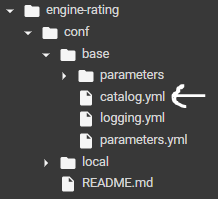


In [ ]:
# Here you can define all your data sets by using simple YAML syntax.
#
# Documentation for this file format can be found in "The Data Catalog"
# Link: https://kedro.readthedocs.io/en/stable/05_data/01_data_catalog.html
#
raw_data:
  type: pandas.ExcelDataSet
  filepath: data/01_raw/dataset.xlsx

clean_data:
  type: MemoryDataSet

target_plot:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/target.png

fig1:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig1.png

fig2:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig2.png

fig3:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig3.png

fig4:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig4.png

fig5:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig5.png

fig6:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig6.png

fig7:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig7.png

fig8:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig8.png

fig9:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig9.png

data_after_eda:
  type: pandas.CSVDataSet
  filepath: data/02_intermediate/data_afterEDA.csv

fig10:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig10.png

fig11:
  type: matplotlib.MatplotlibWriter
  filepath: data/02_intermediate/fig11.png

X_tr:
  type: pickle.PickleDataSet
  filepath: data/04_feature/X_train.pkl
  backend: pickle

X_cr:
  type: pickle.PickleDataSet
  filepath: data/04_feature/X_cv.pkl
  backend: pickle

X_te:
  type: pickle.PickleDataSet
  filepath: data/04_feature/X_test.pkl
  backend: pickle

y_train:
  type: pickle.PickleDataSet
  filepath: data/04_feature/y_train.pkl
  backend: pickle

y_cv:
  type: pickle.PickleDataSet
  filepath: data/04_feature/y_cv.pkl
  backend: pickle

y_test:
  type: pickle.PickleDataSet
  filepath: data/04_feature/y_test.pkl
  backend: pickle

plot_knn:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/KNN/parameter_tuning.png

confusion_knn:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/KNN/confusion_matrix.png  

precision_knn:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/KNN/precision_matrix.png   

recall_knn:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/KNN/recall_matrix.png    

model_knn:
  type: pickle.PickleDataSet
  filepath: data/07_model_output/KNN/model_knn.pkl
  backend: pickle

plot_lr:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Logistic_Regression/parameter_tuning.png

confusion_lr:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Logistic_Regression/confusion_matrix.png  

precision_lr:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Logistic_Regression/precision_matrix.png   

recall_lr:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Logistic_Regression/recall_matrix.png  

model_lr:
  type: pickle.PickleDataSet
  filepath: data/07_model_output/Logistic_Regression/model_lr.pkl
  backend: pickle

plot_svm:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/SVM/parameter_tuning.png

confusion_svm:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/SVM/confusion_matrix.png  

precision_svm:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/SVM/precision_matrix.png   

recall_svm:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/SVM/recall_matrix.png  

model_svm:
  type: pickle.PickleDataSet
  filepath: data/07_model_output/SVM/model_knn.pkl
  backend: pickle

confusion_rf:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Random_Forest/confusion_matrix.png  

precision_rf:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Random_Forest/precision_matrix.png   

recall_rf:
  type: matplotlib.MatplotlibWriter
  filepath: data/07_model_output/Random_Forest/recall_matrix.png  

model_rf:
  type: pickle.PickleDataSet
  filepath: data/07_model_output/Random_Forest/model_rf.pkl
  backend: pickle

##Register all the 4 pipelines in pipeline_registry.py file

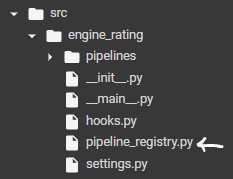

In [ ]:
#This is the code for registering the pipelines so that kedro will know how to execute the pipelines you created. 
#Without this code kedro won't execute your pipelines.
#Write this code in the pipeline_registry.py file
from typing import Dict

from kedro.pipeline import Pipeline
from engine_rating.pipelines import data_cleaning,data_eda,feature_engineering,model_training
from engine_rating.pipelines.data_cleaning.pipeline import create_pipeline

def register_pipelines() -> Dict[str, Pipeline]:
    dc_pipeline = data_cleaning.create_pipeline()
    eda_pipeline = data_eda.create_pipeline()
    fe_pipeline = feature_engineering.create_pipeline()
    model_pipeline = model_training.create_pipeline()
    return {
            "__default__":dc_pipeline + eda_pipeline + fe_pipeline + model_pipeline,
            "dc":dc_pipeline,
            "eda":eda_pipeline,
            "fe":fe_pipeline,
            "training":model_pipeline
            }

##Thats it! You have created an entire pipeline for a data science project using kedros. Lets run the pipeline....

In [7]:
!kedro run

2021-11-13 12:44:09,553 - root - INFO - Registered CLI hooks from 1 installed plugin(s): kedro-telemetry-0.1.3
2021-11-13 12:44:09,629 - root - INFO - Registered CLI hooks from 1 installed plugin(s): kedro-telemetry-0.1.3
2021-11-13 12:44:09,632 - kedro_telemetry.plugin - INFO - You have opted into product usage analytics.
2021-11-13 12:44:09,632 - kedro_telemetry.plugin - WARNING - Something went wrong with getting the username to send to Heap. Exception: [Errno 6] No such device or address
2021-11-13 12:44:09,910 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
fatal: not a git repository (or any of the parent directories): .git
2021-11-13 12:44:09,916 - kedro.framework.session.session - WARNING - Unable to git describe /content/engine-rating
2021-11-13 12:44:09,922 - root - INFO - ** Kedro project engine-rating
/usr/local/lib/python3.7/dist-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pyl

The pipeline executed sucessfully. i.e. your model pipeline has taken a raw dataset, cleaned it, performed EDA on it, performed feature engineering on the features and trained the dataset using different ML models. 

All the plots and trained models are saved in their respective file locations mentioned in the catalog.....!

Lets see some of these results and visualize it. 

###Visualizing few EDA plots

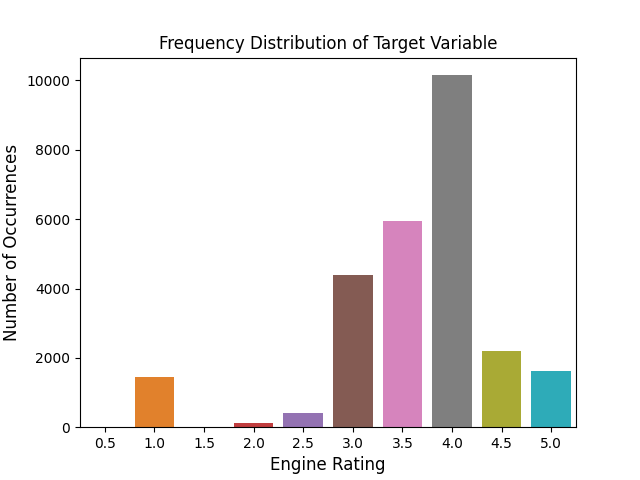

In [15]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/engine-rating/data/02_intermediate/target.png') 
cv2_imshow(img) 

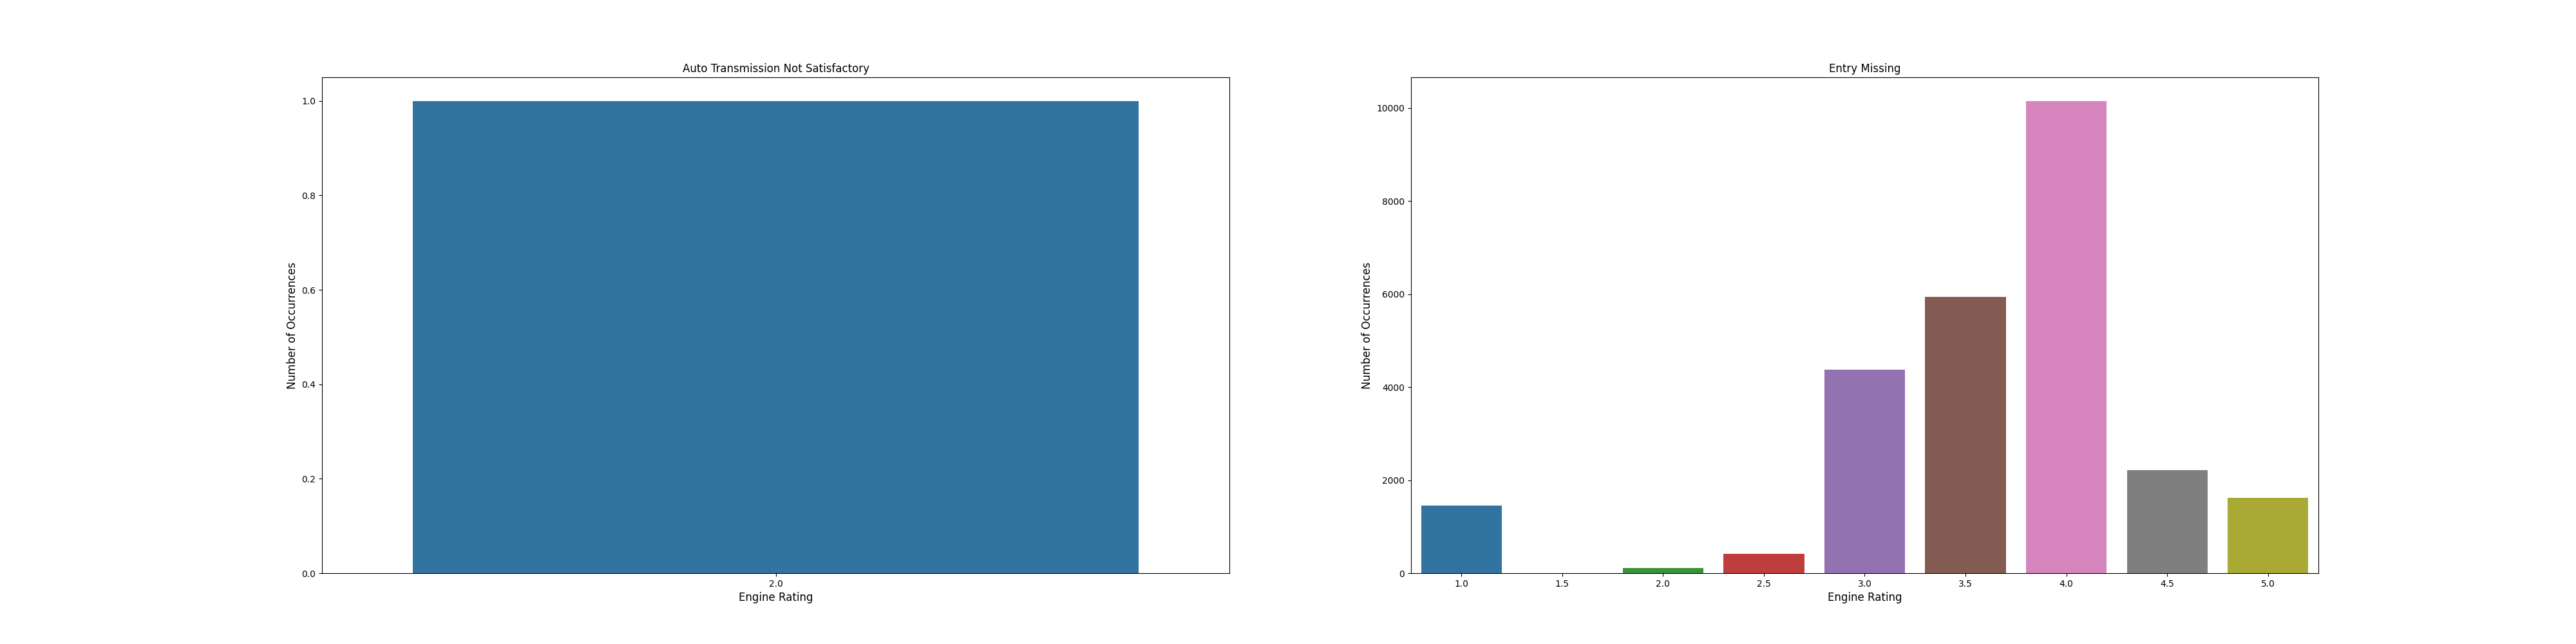

In [16]:
img = cv2.imread('/content/engine-rating/data/02_intermediate/fig1.png') 
cv2_imshow(img) 

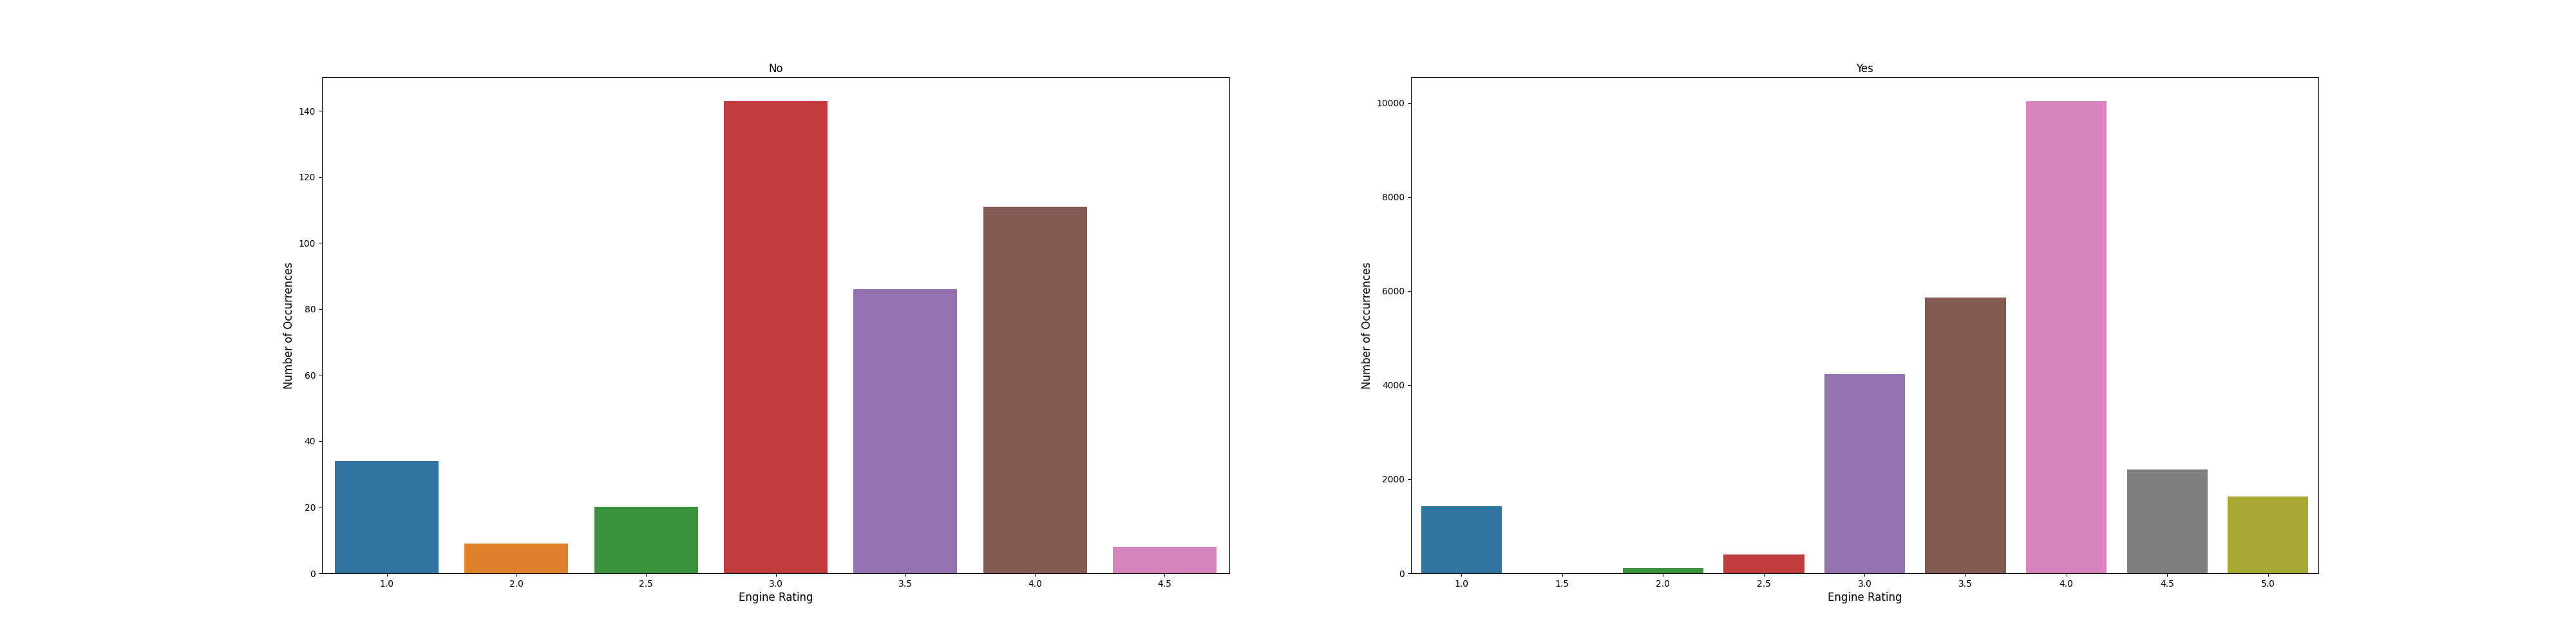

In [17]:
img = cv2.imread('/content/engine-rating/data/02_intermediate/fig8.png') 
cv2_imshow(img) 

####Visualizing KNN model performance

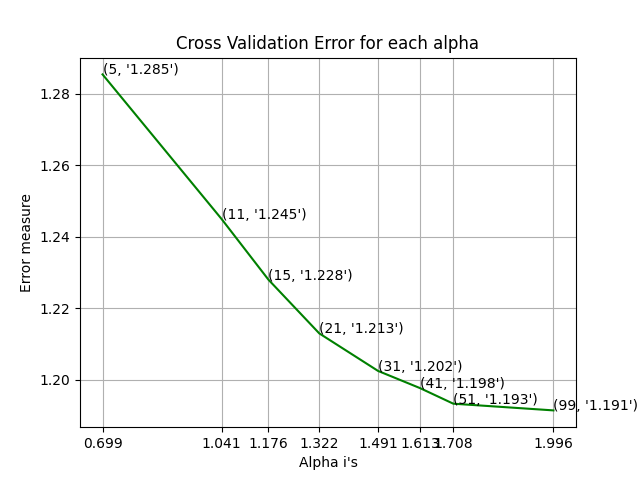

In [18]:
img = cv2.imread('/content/engine-rating/data/07_model_output/KNN/parameter_tuning.png') 
cv2_imshow(img) 

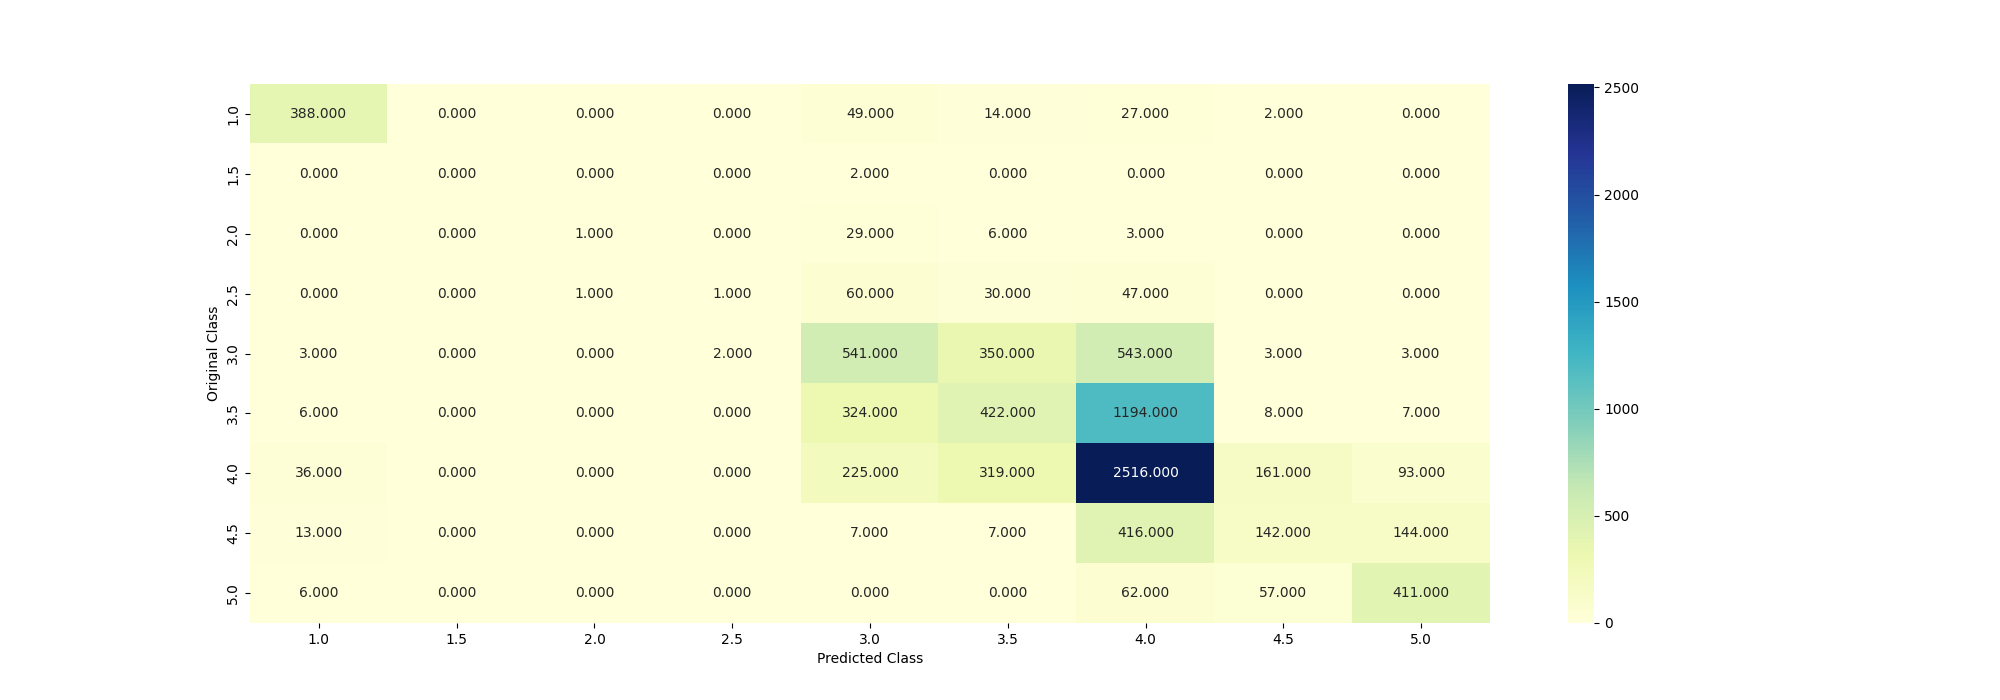

In [19]:
img = cv2.imread('/content/engine-rating/data/07_model_output/KNN/confusion_matrix.png') 
cv2_imshow(img) 

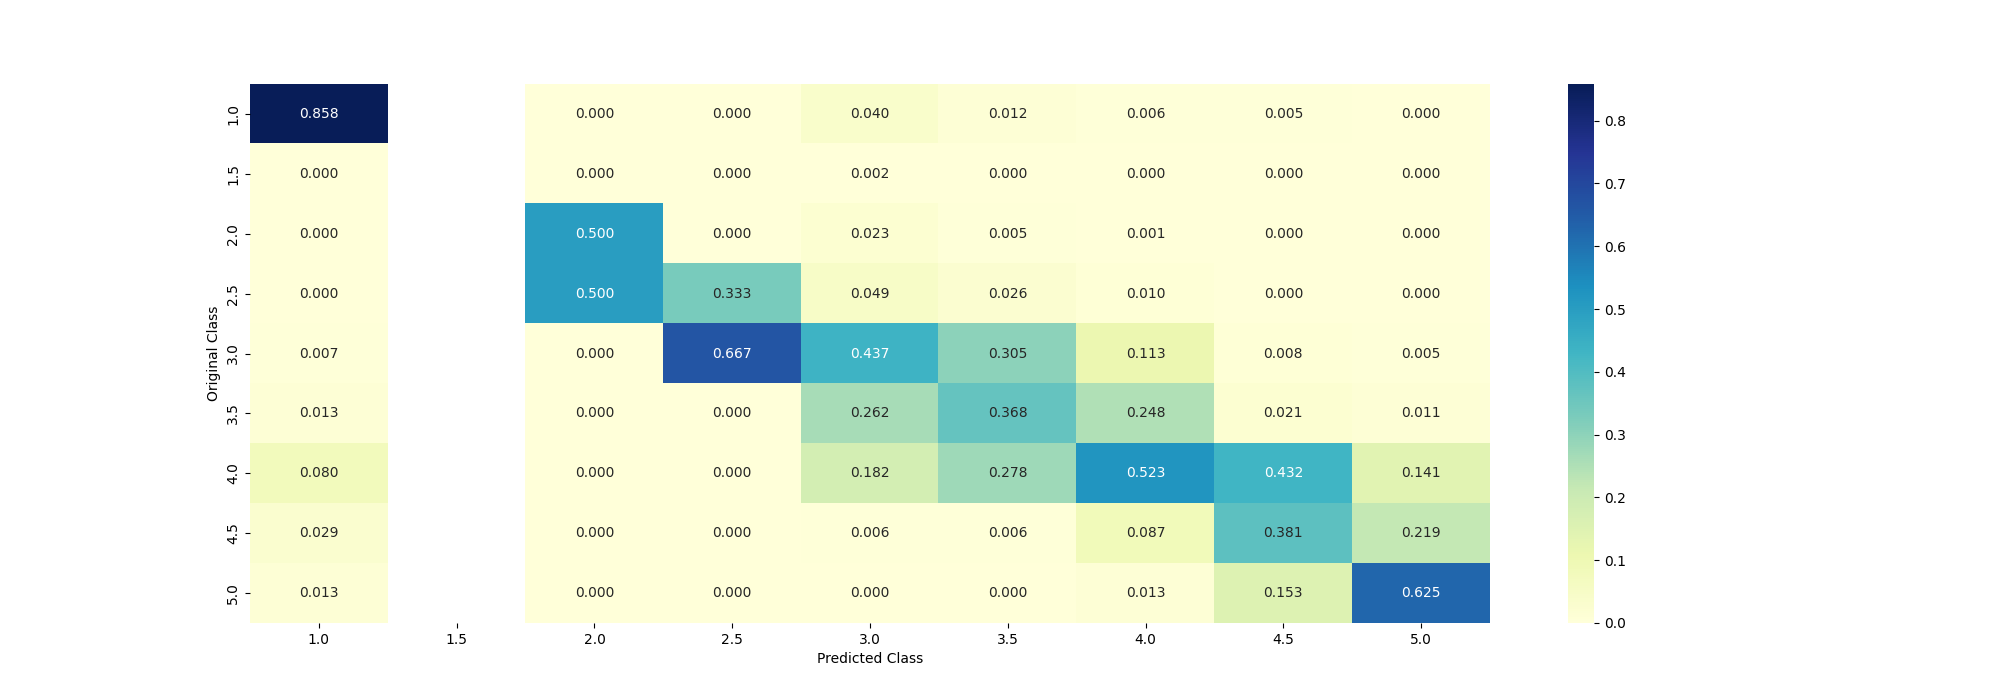

In [20]:
img = cv2.imread('/content/engine-rating/data/07_model_output/KNN/precision_matrix.png') 
cv2_imshow(img) 

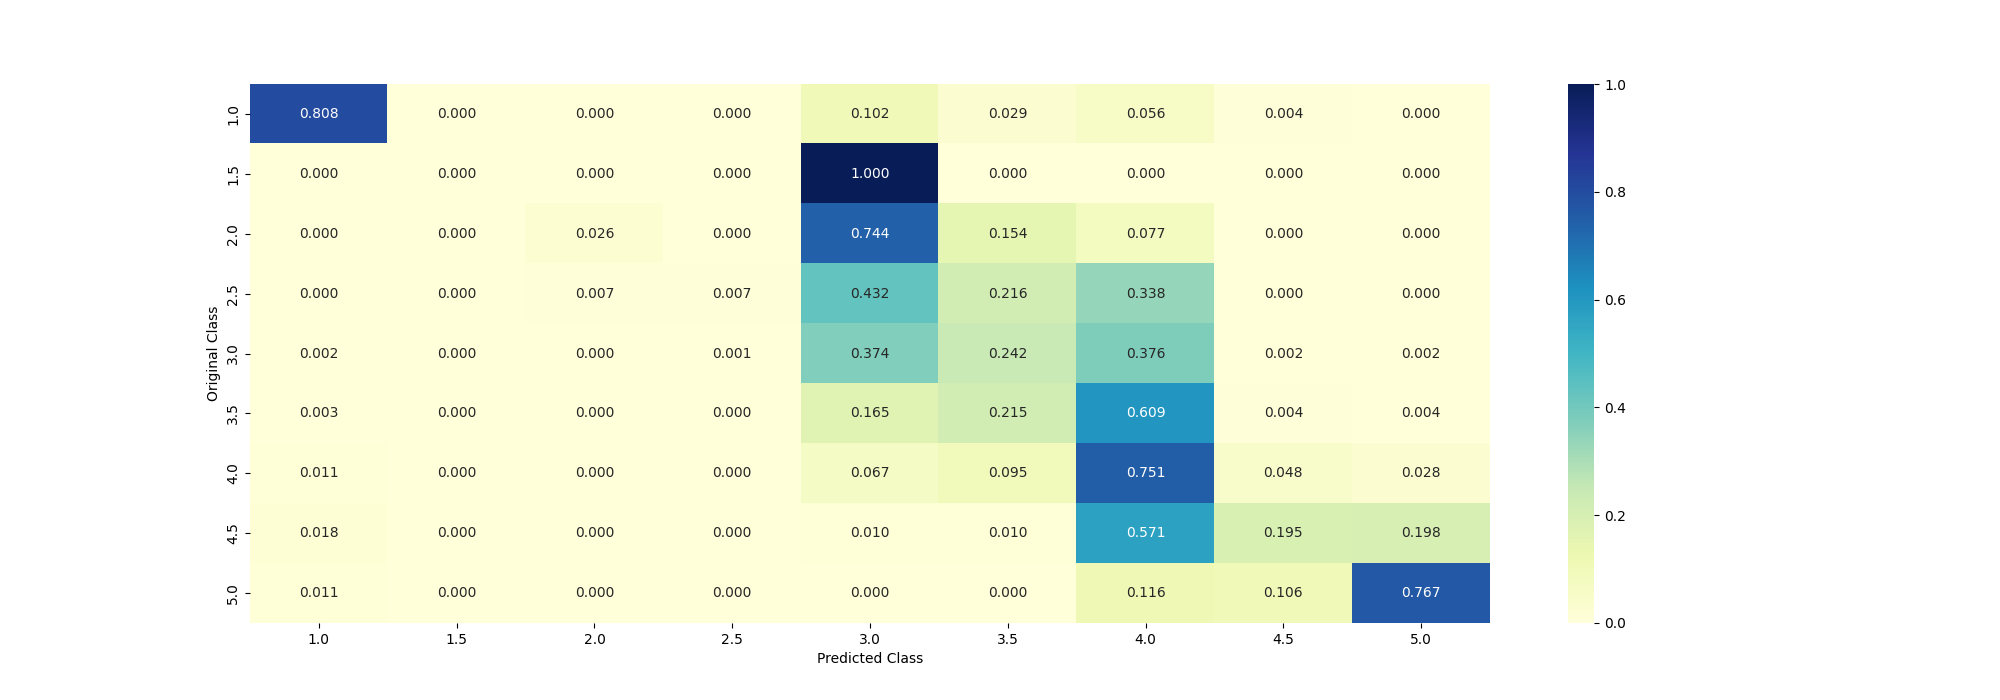

In [21]:
img = cv2.imread('/content/engine-rating/data/07_model_output/KNN/recall_matrix.png') 
cv2_imshow(img) 

Similarly you can open the respective file location and visualize the results for all the models. 